## END-TO-END SYSTEM TESTBENCH

This notebook takes input from the input.dat file and the output from out.gold.dat. From the input, the correlator IP tries to find out the which codes correlates the most with the input.

In [1]:
from pynq import Overlay
import numpy as np
from pynq import Xlnk
from pynq.lib import dma
from scipy.linalg import dft
import matplotlib.pyplot as plt

In [27]:
ol=Overlay('correlator.bit')

In [28]:
dma1=ol.correlator_ss.axi_dma_0

We are loading the input and the golden output from their respective dat files. The input is sent to the IP using the dma send channel and the output is obtained from the IP using the dma receive channel.
Therefore, only one component of DMA IP is enough to execute the code.

In [ ]:
input_filename = 'input.dat'
input_data = np.fromfile(input_filename, dtype=float)

output_filename = 'out.gold.dat'
golden_op = np.fromfile(output_filename, dtype=float)

In [29]:
NUM_CODES = len(output_data)
INPUT_LENGTH = len(input_data)

error = np.zeros(NUM_CODES)
ind = np.arange(NUM_CODES)
rmse = np.zeros(NUM_CODES)


In [30]:
xlnk = Xlnk()
in1 = xlnk.cma_array(shape=(NUM_LENGTH,), dtype=np.float32) 
out1 = xlnk.cma_array(shape=(NUM_CODES,), dtype=np.float32) 

np.copyto(in1, input_data)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: pynq.Xlnk is deprecated and will be removed in 2.7 - use pynq.allocate instead
  """Entry point for launching an IPython kernel.


In [33]:

correlator_ip = ol.correlator_ss.correlator_0
correlator_ip.write(0x00,1)
dma1.recvchannel.start()
dma1.sendchannel.start()

dma1.recvchannel.transfer(out1)
dma1.sendchannel.transfer(in1)

# Wait for the DMA to send and recv data.
dma1.recvchannel.wait()
dma1.sendchannel.wait()

## Verifying Functionality 

In [34]:

for i in range(NUM_CODES):
    error[i]="{0:.6f}".format(abs(out1[i]-golden_op[i]))

In [35]:
sum_sq=0
for i in range(NUM_SAMPLES):
    sum_sq =sum_sq+(error[i]*error[i])
    rmse = np.sqrt(sum_sq_real / (i+1))
print("RMSE: ", rmse)    
if rmse<0.1:
    print("PASS")
else:
    print("FAIL")

Real Part RMSE:  1.2013298295534854e-05 Imaginary Part RMSE: 4.895988472719265e-06
PASS


## Displaying Error and Output

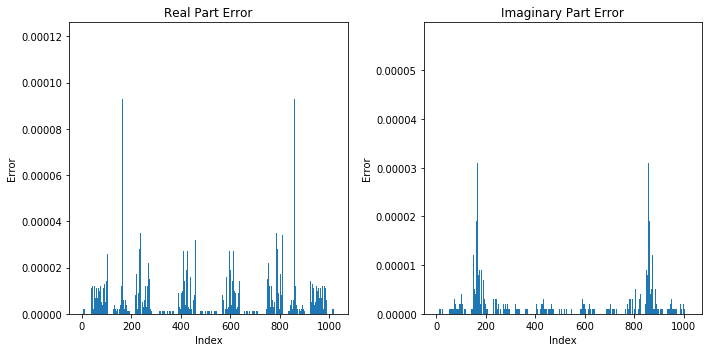

In [36]:
plt.figure(figsize=(10, 5))
plt.subplot(1,1,1)
plt.bar(ind,real_error)
plt.title("RMSE Error")
plt.xlabel("Index")
plt.ylabel("Error")
#plt.xticks(ind)
plt.tight_layout()